# Background

- The platform has 6 years worth of data.
- Problem: Issues with retention, reengagement, campaign targeting, and lack of general understanding of the user base
- Ask: How to group players based on recent behavior, general purchase behavior, and extreme purchase behavior

# Data Profile

- Business domain: scheduling platform for services
- Snapshot date: 2022-09-03
- Disclaimer: Data is private and have been masked. It will not be shared.

# Setup

In [1]:
%pip install ../.

Processing c:\users\franc\git-repo\scheduling-platform-segmentation
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scheduling-platform-segmentation: filename=scheduling_platform_segmentation-0.0.1-py3-none-any.whl size=4439 sha256=a6a744a90e6300f30d97df748a551f6685f2782a274e6c49c7fc9bfb425c8967
  Stored in directory: c:\users\franc\appdata\local\pip\cache\wheels\0f\b0\cc\22072402b1c65edb72b7efff9548c7464e42d8420b35ab478b
Successfully built scheduling-platform-segmentation
  Attempting uninstall: scheduling-platform-segmentation
    Found existing installation: scheduling-platform-segmentation 0.0.1
    Uninstalling scheduling-platform-segmentation-0.0.1:
      Successfully uninstalled scheduling-platform-segmentation-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from copy import deepcopy

from scheduling_platform_segmentation.constants import QUANTILE_LIST, TRAD_RF_SEGMENTS_LIST
from scheduling_platform_segmentation.preprocess.rfm import (
    generate_quantile_dictionary,
    generate_conditions,
    generate_trad_rf_segments
)

import warnings
warnings.filterwarnings("ignore")

In [3]:
pdf_raw_user_by_vendor_by_store = pd.read_csv('user_data_by_vendor_by_store.csv')
pdf_raw_user_by_vendor_by_store = pdf_raw_user_by_vendor_by_store[[c for c in pdf_raw_user_by_vendor_by_store.columns if c != 'Unnamed: 0']]
pdf_raw_user_by_vendor_by_store

,user_id,install_date,vendor_id,store_id,tenure,store_days_since_last_transaction,store_num_transactions,store_total_dollar_spend
0,142488,2022-07-23,195,269,41.737250,12.899776,2,15400.0
1,133793,2022-06-01,195,269,93.859821,20.668556,3,33000.0
2,139901,2022-07-09,195,269,55.806231,55.806223,1,33000.0
3,134030,2022-06-02,195,269,92.660766,63.704679,3,19600.0
4,140978,2022-07-14,195,269,50.750846,23.745670,3,13400.0
...,...,...,...,...,...,...,...,...
92250,110297,2021-11-29,139,219,277.861396,81.845761,2,50300.0
92251,108382,2021-11-15,139,219,291.649244,88.853760,2,59196.0
92252,123325,2022-03-22,139,219,164.875360,95.752685,1,67050.0
92253,17108,2018-08-22,146,226,1472.914944,415.731643,1,500.0


In [4]:
pdf_raw_user_purchase_behavior = pd.read_csv('user_data_purchase_behavior.csv')
pdf_raw_user_purchase_behavior = pdf_raw_user_purchase_behavior[[c for c in pdf_raw_user_purchase_behavior.columns if c != 'Unnamed: 0']]
pdf_raw_user_purchase_behavior

,user_id,num_vendors,num_success_vendors,prop_successfully_tried_vendors,num_service_categories,num_success_service_categories,prop_successfully_tried_servicecategory,total_successful_txns,prop_success_txns,total_transactions,total_transactions_amount,transaction_amount_mean,transaction_amount_median,transaction_amount_min,transaction_amount_max,days_between_successful_txn_dates_mean,days_between_successful_txn_dates_median,days_between_successful_txn_dates_min,days_between_successful_txn_dates_max
0,76416,1,1,1,1,1,1.0,1,1.000000,1,20.0,20.000000,20.0,20.0,20.0,NaN,NaN,NaN,NaN
1,83859,1,1,1,1,1,1.0,1,1.000000,1,20.0,20.000000,20.0,20.0,20.0,NaN,NaN,NaN,NaN
2,8708,1,1,1,1,1,1.0,1,1.000000,1,50.0,50.000000,50.0,50.0,50.0,NaN,NaN,NaN,NaN
3,18995,1,1,1,1,1,1.0,1,1.000000,1,50.0,50.000000,50.0,50.0,50.0,NaN,NaN,NaN,NaN
4,76764,1,1,1,1,1,1.0,1,1.000000,1,50.0,50.000000,50.0,50.0,50.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87029,14834,1,1,1,1,1,1.0,998,0.996008,1002,295970.0,296.860582,300.0,0.0,500.0,0.074223,0.0,0.0,8.0
87030,14311,1,1,1,4,4,1.0,8167,0.994884,8209,1114332.5,136.460017,150.0,0.0,920.0,0.000490,0.0,0.0,3.0
87031,13774,1,1,1,3,3,1.0,2024,0.995573,2033,598750.0,295.971330,300.0,0.0,1100.0,0.014335,0.0,0.0,4.0
87032,5898,1,1,1,1,1,1.0,234,0.947368,247,85398.0,366.515021,350.0,0.0,2620.0,0.381974,0.0,0.0,25.0


# Recent Purchase Behavior

In [5]:
pdf_raw_user_by_vendor_by_store

,user_id,install_date,vendor_id,store_id,tenure,store_days_since_last_transaction,store_num_transactions,store_total_dollar_spend
0,142488,2022-07-23,195,269,41.737250,12.899776,2,15400.0
1,133793,2022-06-01,195,269,93.859821,20.668556,3,33000.0
2,139901,2022-07-09,195,269,55.806231,55.806223,1,33000.0
3,134030,2022-06-02,195,269,92.660766,63.704679,3,19600.0
4,140978,2022-07-14,195,269,50.750846,23.745670,3,13400.0
...,...,...,...,...,...,...,...,...
92250,110297,2021-11-29,139,219,277.861396,81.845761,2,50300.0
92251,108382,2021-11-15,139,219,291.649244,88.853760,2,59196.0
92252,123325,2022-03-22,139,219,164.875360,95.752685,1,67050.0
92253,17108,2018-08-22,146,226,1472.914944,415.731643,1,500.0


In [6]:
pdf_user_level = (
    pdf_raw_user_by_vendor_by_store
    .groupby('user_id')
    .agg(install_date=('install_date', 'min'),
         cnt_vendors=('vendor_id', 'nunique'),
         tenure=('tenure', 'max'),
         recency=('store_days_since_last_transaction', 'min'),
         frequency=('store_num_transactions', 'sum'),
         monetary=('store_total_dollar_spend', 'sum')
         )
    )

In [7]:
dict_quantile = generate_quantile_dictionary(pdf_user_level, QUANTILE_LIST) # save this into database

pdf_rfm_scored = deepcopy(pdf_user_level)
for metric in dict_quantile.keys():
    if metric in ('recency'):
        reverse = 1
    else:
        reverse = 0

    conditions, values = generate_conditions(pdf_rfm_scored, dict_quantile, metric, reverse=reverse)
    pdf_rfm_scored[metric[0]] = np.select(conditions, values)

In [8]:
pdf_rfm_labeled = generate_trad_rf_segments(pdf_rfm_scored)
pdf_rfm_labeled

,install_date,cnt_vendors,tenure,recency,frequency,monetary,t,r,f,m,wtd_rfm
106246,2021-10-30,1,307.799153,121.934572,6,90396.0,1,5,5,5,champions
106247,2021-10-30,1,307.797483,139.782477,1,3826.0,1,5,1,5,new_customers
106251,2021-10-30,1,307.784611,307.784600,1,42800.0,1,4,1,5,promising
106252,2021-10-30,1,307.776173,223.626908,2,1495.0,1,4,4,4,loyal_customers
106254,2021-10-30,1,307.769778,117.760101,2,1496.0,1,5,4,4,champions
...,...,...,...,...,...,...,...,...,...,...,...
34853,2019-03-09,1,1273.808965,985.000000,4,1745.0,5,2,5,4,cant_lose
34854,2019-03-09,1,1273.799046,1080.489532,2,790.0,5,2,4,3,at_risk
34855,2019-03-09,1,1273.781311,1147.726193,1,450.0,5,1,1,2,hibernating
34856,2019-03-09,1,1273.769372,1084.455102,2,845.0,5,2,4,4,at_risk


In [9]:
pdf_summary = (
    pdf_rfm_labeled
    .groupby(['wtd_rfm', 't'])
    .describe()[[('tenure', 'count'), 
                ('recency', 'mean'), #('recency', '50%'), 
                ('frequency', 'mean'), #('frequency', '50%'), 
                ('monetary', 'mean'), #('monetary', '50%')
                ]]
    .reset_index()
    )

pdf_summary.columns = ['segment', 'tenure', 'cnt_users', 
                       'recency_mean', #'recency_median', 
                       'frequency_mean', #'frequency_median', 
                       'monetary_mean', #'monetary_median'
                       ]

pdf_summary = pdf_summary.sort_values(['tenure', 'segment']).set_index(['tenure', 'segment'])
pdf_summary

cnt_users  recency_mean  frequency_mean  monetary_mean
tenure segment                                                                
1      champions           2397.0     67.300643        2.786400    7722.003087
       loyal_customers      209.0    235.982359        2.157895    6870.306220
       new_customers      11088.0     91.972988        1.000000    2221.260732
       promising           3713.0    251.336164        1.000000    2293.652572
2      about_to_sleep      5486.0    653.309957        1.000000     254.478163
       champions           1556.0     77.952291        4.016067    9740.802314
       loyal_customers     2138.0    487.562068        2.624415    1991.683630
       new_customers        284.0     96.500293        1.000000    3262.563380
       promising           7943.0    509.049597        1.000000     964.611180
3      about_to_sleep      8148.0    730.733086        1.000000     249.491163
       at_risk              294.0    907.107625        2.000000    1225.442177
       cant_lose            100.0    907.391520        3.490000    2130.650000
       champions            277.0     69.286398        7.447653    4908.761733
       hibernating         3993.0    851.489779        1.000000     367.775482
       loyal_customers     4546.0    639.024032        3.078311     820.244061
       new_customers          9.0    108.985974        1.000000    1605.333333
       promising             39.0    467.649378        1.000000     546.794872
4      about_to_sleep        19.0    697.432204        1.000000     539.473684
       at_risk             2613.0   1061.832526        2.000000    1177.662457
       cant_lose           3008.0   1001.462601        5.272939    3252.853142
       champions            562.0     72.270062       13.186833    7573.289146
       hibernating        10243.0   1122.149329        1.000000     578.568827
       loyal_customers      926.0    538.295299        5.855292    3007.609071
       new_customers         11.0    119.471380        1.000000     648.909091
       promising             25.0    425.968545        1.000000     627.360000
5      about_to_sleep        36.0    710.145694        1.000000     534.583333
       at_risk             2526.0   1363.040907        2.000000    1004.694652
       cant_lose           4967.0   1170.440644       14.039058    4999.566807
       champions           1160.0     73.786930       15.587069    8074.238793
       hibernating         7070.0   1495.983133        1.000000     550.104560
       loyal_customers     1507.0    498.482375       10.832780    5244.050431
       new_customers         63.0    102.099446        1.000000     650.888889
       promising             78.0    378.118750        1.000000     638.358974

# ML-based clustering

In [10]:
pdf_gen = deepcopy(pdf_rfm_labeled)
pdf_gen['avg_txn_amount'] = pdf_gen['monetary'] / pdf_gen['frequency']
pdf_gen['cnt_vendors'] = pdf_gen['cnt_vendors'].astype(int)
pdf_gen_feat = pdf_gen[['cnt_vendors', 'tenure', 'recency', 'frequency', 'monetary', 'avg_txn_amount']]

In [11]:
pdf_gen_log = np.log1p(pdf_gen_feat)
pdf_gen_log

,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
106246,0.693147,5.732691,4.811652,1.945910,11.411966,9.620262
106247,0.693147,5.732686,4.947216,0.693147,8.249836,8.249836
106251,0.693147,5.732644,5.732644,0.693147,10.664317,10.664317
106252,0.693147,5.732617,5.414441,1.098612,7.310550,6.618071
106254,0.693147,5.732596,4.777106,1.098612,7.311218,6.618739
...,...,...,...,...,...,...
34853,0.693147,7.150552,6.893656,1.609438,7.465083,6.080505
34854,0.693147,7.150544,6.986095,1.098612,6.673298,5.981414
34855,0.693147,7.150530,7.046409,0.693147,6.111467,6.111467
34856,0.693147,7.150521,6.989755,1.098612,6.740519,6.048554


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, BisectingKMeans
from sklearn.neighbors import NearestNeighbors

import kneed
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
scaler = StandardScaler()
scaler.fit(pdf_gen_log)
arr_processed = scaler.transform(pdf_gen_log)
pdf_processed = pd.DataFrame(arr_processed, columns=pdf_gen_log.columns, index=pdf_gen_log.index)
pdf_processed.head()

,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
106246,-0.106311,-0.667728,-1.155880,1.854235,4.305358,4.116740
106247,-0.106311,-0.667734,-1.040042,-0.545884,1.507341,2.502396
106251,-0.106311,-0.667775,-0.368904,-0.545884,3.643799,5.346622
106252,-0.106311,-0.667802,-0.640805,0.230931,0.676211,0.580198
106254,-0.106311,-0.667823,-1.185400,0.230931,0.676803,0.580984


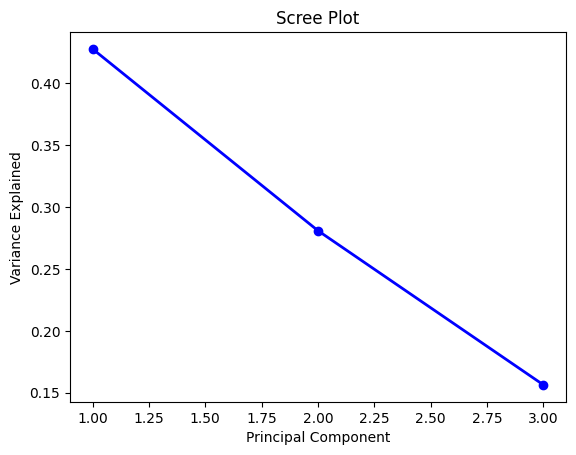

In [14]:
#define PCA model to use
pca = PCA(n_components=3)

#fit PCA model to data
pca_fit = pca.fit(pdf_processed)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [15]:
#define PCA model to use
pca = PCA(n_components=2)

#fit PCA model to data
pca_fit_transformed = pca.fit_transform(pdf_processed)

In [16]:
pca_fit_transformed

array([[ 5.48888494,  2.29758365],
       [ 2.7310848 , -0.38345361],
       [ 4.94398075,  0.73756214],
       ...,
       [-1.00026977,  0.09237698],
       [-0.58714767,  0.80485476],
       [-1.18254248,  0.06920698]])

# General Purchase Behavior

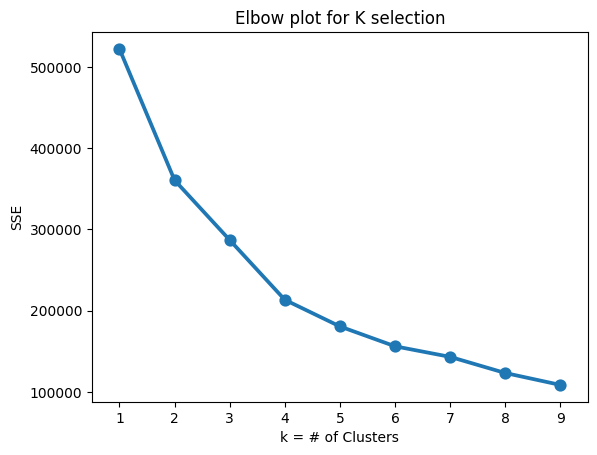

Knee:  4


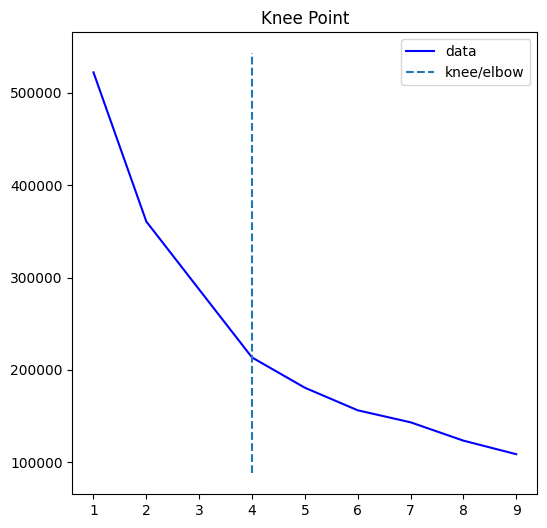

In [18]:
# k=4
sse = {}
for k in range(1,10):
    model_clustering = BisectingKMeans(n_clusters=k, random_state=100)
    model_clustering.fit(pdf_processed)
    sse[k] = model_clustering.inertia_

plt.title('Elbow plot for K selection')
plt.xlabel('k = # of Clusters')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
                y=list(sse.values()))
plt.show()

kneedle = kneed.KneeLocator(x=list(sse.keys()), y=list(sse.values()), curve='convex', direction='decreasing')
knee_point = kneedle.knee #elbow_point = kneedle.elbow
print('Knee: ', knee_point) #print('Elbow: ', elbow_point)
kneedle.plot_knee()

In [20]:
# centroid based clustering
k = 4
model_clustering = BisectingKMeans(n_clusters=k, random_state=100)
model_clustering.fit(pca_fit_transformed)

BisectingKMeans(n_clusters=4, random_state=100)

# Extreme Purchase Behavior

In [21]:
# Find best EPS and min_sample
nn = NearestNeighbors(n_neighbors=20).fit(pdf_gen_log)
distances, indices = nn.kneighbors(pdf_gen_log)

In [48]:
# density based clustering
min_samples = 9
eps=0.25
model_clustering_DBSCAN = DBSCAN(min_samples=min_samples, eps=eps, n_jobs=-1)
model_clustering_DBSCAN.fit(pca_fit_transformed)

DBSCAN(eps=0.25, min_samples=9, n_jobs=-1)

# Combine Labels

In [52]:
pdf_clustered = pd.concat(
    [pdf_gen.reset_index(), pd.DataFrame(pca_fit_transformed, columns=['component1', 'component2'])], axis=1
)
pdf_clustered['density_clusters'] = model_clustering_DBSCAN.labels_
pdf_clustered['centroid_clusters'] = model_clustering.labels_
pdf_clustered = pdf_clustered.rename({'index': 'user_id'}, axis=1)
pdf_clustered.head()

,user_id,install_date,cnt_vendors,tenure,recency,frequency,monetary,t,r,f,m,wtd_rfm,avg_txn_amount,component1,component2,density_clusters,centroid_clusters
0,106246,2021-10-30,1,307.799153,121.934572,6,90396.0,1,5,5,5,champions,15066.0,5.488885,2.297584,0,2
1,106247,2021-10-30,1,307.797483,139.782477,1,3826.0,1,5,1,5,new_customers,3826.0,2.731085,-0.383454,0,3
2,106251,2021-10-30,1,307.784611,307.784600,1,42800.0,1,4,1,5,promising,42800.0,4.943981,0.737562,0,2
3,106252,2021-10-30,1,307.776173,223.626908,2,1495.0,1,4,4,4,loyal_customers,747.5,1.261002,-0.136324,0,3
4,106254,2021-10-30,1,307.769778,117.760101,2,1496.0,1,5,4,4,champions,748.0,1.536315,-0.298096,0,3


In [53]:
(
    pdf_clustered
    .groupby('density_clusters')
    .describe()[[('user_id', 'count'),
                 ('cnt_vendors', 'mean'),
                 ('tenure', 'mean'),
                 ('recency', 'mean'),
                 ('frequency', 'mean'),
                 ('monetary', 'mean'),
                 ('avg_txn_amount', 'mean'),
                 ]]
    )

,user_id,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
,count,mean,mean,mean,mean,mean,mean
density_clusters,,,,,,,
-1,299.0,1.525084,730.282405,255.008293,151.157191,75441.589298,9935.356553
0,86692.0,1.009678,835.362162,716.592462,2.215349,1646.013317,884.365667
1,9.0,1.000000,33.332387,28.638729,1.111111,26168.888889,25168.888889
2,11.0,1.000000,3.265437,3.265384,1.000000,1760.000000,1760.000000
3,10.0,1.900000,329.371037,51.303699,5.900000,68160.200000,14526.090866
4,13.0,1.000000,1085.748072,1085.747953,1.000000,100.000000,100.000000


In [55]:
(
    pdf_clustered
    .groupby('centroid_clusters')
    .describe()[[('user_id', 'count'),
                 ('cnt_vendors', 'mean'),
                 ('tenure', 'mean'),
                 ('recency', 'mean'),
                 ('frequency', 'mean'),
                 ('monetary', 'mean'),
                 ('avg_txn_amount', 'mean'),
                 ]]
    )

,user_id,cnt_vendors,tenure,recency,frequency,monetary,avg_txn_amount
,count,mean,mean,mean,mean,mean,mean
centroid_clusters,,,,,,,
0,13986.0,1.014300,1337.098666,948.157651,8.329973,3577.528193,628.098597
1,50697.0,1.000000,937.613142,900.313406,1.224786,399.811813,337.245838
2,4625.0,1.174054,707.186858,186.420514,8.124757,15537.001406,7139.071695
3,17726.0,1.000000,177.690435,138.084512,1.194234,1355.511870,1192.056589


# Cluster Analysis
## Composition

In [56]:
pdf_cluster_composition = pdf_clustered.groupby(['centroid_clusters', 'density_clusters']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('density_clusters')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
pdf_cluster_composition.unstack('centroid_clusters', fill_value=0)['pct_of_cluster']


centroid_clusters,0,1,2,3
density_clusters,,,,
-1,0.130435,0.043478,0.635452,0.190635
0,0.160880,0.584495,0.050939,0.203687
1,0.000000,0.000000,1.000000,0.000000
2,0.000000,0.000000,0.000000,1.000000
3,0.000000,0.000000,1.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000


In [57]:
pdf_cluster_composition = pdf_clustered.groupby(['centroid_clusters', 'wtd_rfm']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('wtd_rfm')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
pdf_cluster_composition.unstack('centroid_clusters', fill_value=0)['pct_of_cluster']


centroid_clusters,0,1,2,3
wtd_rfm,,,,
about_to_sleep,0.000073,0.998539,0.000073,0.001315
at_risk,0.249402,0.739186,0.011412,0.000000
cant_lose,0.958266,0.025139,0.016594,0.000000
champions,0.074765,0.006384,0.542339,0.376512
hibernating,0.045339,0.940580,0.008918,0.005163
loyal_customers,0.373150,0.544499,0.036136,0.046215
new_customers,0.000000,0.006373,0.029245,0.964382
promising,0.000085,0.642482,0.028649,0.328785


In [58]:
pdf_cluster_composition = pdf_clustered.groupby(['density_clusters', 'wtd_rfm']).agg(
    cnt_users=('user_id', 'nunique')
)
pdf_cluster_composition['cohort_size'] = pdf_cluster_composition.groupby('wtd_rfm')['cnt_users'].transform(
    'sum'
)
pdf_cluster_composition['pct_of_cluster'] = pdf_cluster_composition['cnt_users'] / pdf_cluster_composition['cohort_size']
pdf_cluster_composition.unstack('density_clusters', fill_value=0)['pct_of_cluster']


density_clusters,-1,0,1,2,3,4
wtd_rfm,,,,,,
about_to_sleep,0.000292,0.999708,0.000000,0.00000,0.00000,0.00000
at_risk,0.000184,0.999816,0.000000,0.00000,0.00000,0.00000
cant_lose,0.005077,0.994923,0.000000,0.00000,0.00000,0.00000
champions,0.024026,0.974126,0.000168,0.00000,0.00168,0.00000
hibernating,0.000141,0.999249,0.000000,0.00000,0.00000,0.00061
loyal_customers,0.002681,0.997319,0.000000,0.00000,0.00000,0.00000
new_customers,0.006984,0.991357,0.000698,0.00096,0.00000,0.00000
promising,0.000170,0.999830,0.000000,0.00000,0.00000,0.00000
